First, let's import the libraries we need. You may need to install statsmodels (e.g., `conda install statsmodels`).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

Since you're working with psychometric data, you usually have a stimulus (e.g., a flash of light) that varies along some parameter. Based on the code you sent me for plotting the results, your CSV file appears to have the following columns:

* Flash delay (ms)
* Subject Answer

"Flash delay (ms)" will be the stimulus parameter that varies (i.e., the predictor). I'm *guessing* that "subject answer" is coded as 0 or 1 (i.e., not detected or detected) and that you have exactly 10 trials per stimulus parameter. For now, I am going to assume that flash delay ranges from -100 to 200 msec. You can adjust the numbers as needed.

Most psychometric data follows a psychometric function in which the probability of a correct response improves as the stimulus becomes easier to detect. The detection probability often follows what we call the inverse probit function (i.e., the cumulative function of a normal distribution). That's why you're being asked to fit the data to a cumulative normal function. Note that gaussian and normal are interchangable terms for the same distribution. You're probably already familiar with the probability density function of the normal distribution (it's the classic plot that's usually shown in classes when presenting a gaussian or normal distribution; see https://en.wikipedia.org/wiki/Normal_distribution).

Scipy's statistics module comes with several classes for common distributions including the normal/gaussian. The classes have classmethods (e.g., pdf, cdf) that can be used to calculate the probability and cumulative density functions.

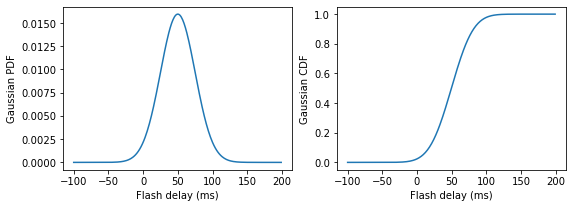

In [2]:
flash_delay = np.arange(-100, 200, 1)

# You can play with these parameters to see how the plots change
norm_mean = 50     # center of the normal PDF (midpoint of the normal CDF)
norm_stdev = 25    # width of the normal PDF (slope of the normal CDF)

# Calculate the PDF of the normal distribution for the specified mean/stdev
gaussian_pdf = stats.norm.pdf(flash_delay, norm_mean, norm_stdev)

# The CDF is just the cumulative sum of the PDF
gaussian_cdf = gaussian_pdf.cumsum()

figure, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(flash_delay, gaussian_pdf)
axes[0].set_xlabel('Flash delay (ms)')
axes[0].set_ylabel('Gaussian PDF')
axes[1].plot(flash_delay, gaussian_cdf)
axes[1].set_xlabel('Flash delay (ms)')
axes[1].set_ylabel('Gaussian CDF')

# Alternatively, we can just calculate the gaussian_cdf using the cdf class method
gaussian_cdf = stats.norm.cdf(flash_delay, norm_mean, norm_stdev)

Now, we need to generate some simulated data that we can work with. Since most of our functions require the response variable to be expressed in probability on the scale of 0 (i.e., 0%) to 1 (i.e., 100%). To differentiate between these two, I will call this "fraction" correct (as opposed to "percent" correct).

Text(0.5, 1.0, 'Simulated subject response')

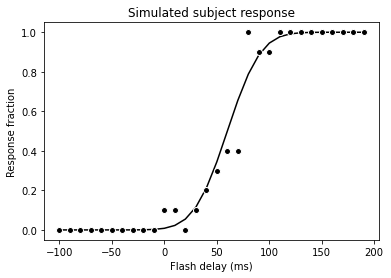

In [3]:
# This is the subject's true threshold (equivalent to the "mean" of the distribution)
threshold = 60

# This is the slope of the subject's response (equivalent to the standard deviation of the distribution)
slope = 25

# The number of trials per flash delay
n_trials = 10

# The flash delays actually tested in our simulation
test_flash_delay = np.arange(-100, 200, 10)

# The number of correct responses for the subject. First, we need to generate the "true" 
subject_fraction_correct = stats.norm.cdf(test_flash_delay, threshold, slope)
simulated_correct_responses = np.random.binomial(n_trials, subject_fraction_correct)
simulated_subject_fraction_correct = simulated_correct_responses / n_trials

figure, axes = plt.subplots(1, 1)
axes.plot(test_flash_delay, subject_fraction_correct, 'k-')
axes.plot(test_flash_delay, simulated_subject_fraction_correct, 'ko', mec='w')
axes.set_xlabel('Flash delay (ms)')
axes.set_ylabel('Response fraction')
axes.set_title('Simulated subject response')

There are several approaches to fitting this type of function. I'll focus on the one most similar to what Dr. Peterka suggested in Matlab. Let's assume that the response varies from 0 (0% probability of responding) to 1 (100% probability of responding). This is not always the case, but I looked up some previous publications of Tim Hullar's and it looks like they generally make that assumption, e.g., from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6230789/. 

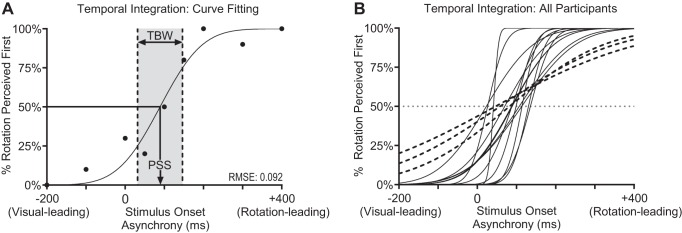

If the response does not vary from 0 to 1, then there is an alternate method we might need to use (this sometimes happens in psychoacoustics).

The closest thing to Matlab's `glmfit` function would be statsmodel's GLM class. First, let's package our simulated subject response into a dataframe since statsmodels plays very nicely with dataframes. Make sure that the dataframe column names can be considered valid Python variable names so that we can write our model as a formula. This means that you can't have column names like `'flash delay (ms)'` or `'flash delay'` (i.e., no whitespace or special characters).

In [4]:
# First, let's package our simulated response data into a DataFrame
data = pd.DataFrame({
    'flash_delay': test_flash_delay,
    'fraction_correct': simulated_subject_fraction_correct,
})

Let's start with a basic linear regression model. This is how we would fit a straight line to the data (remember `y = m * x + b` from linear algebra?). This is the default when fitting a general linear regression model (i.e., we do not need to specify link or family, but I am doing so here to be explicit). In this case, `y` is the `fraction_correct` and `m` is `flash_delay` (statsmodels automatically adds `b`, which is also known as the intercept).

As you can see, this is not a very good representation of the data. That's because the data does not really follow a straight line.

Text(0, 0.5, 'Response fraction')

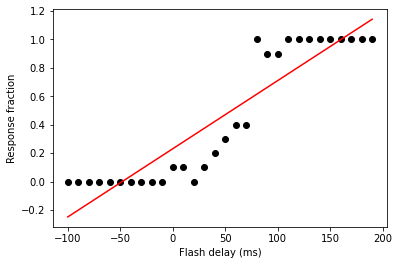

In [5]:
link = sm.families.links.identity()
family = sm.families.Gaussian(link=link)

# Formulas are specified in the form `outcome ~ predictors`
fit = sm.GLM.from_formula('fraction_correct~flash_delay', data=data, family=family).fit()
data['predicted_fraction_correct'] = fit.predict(data['flash_delay'])

figure, axes = plt.subplots(1, 1)
axes.plot(data['flash_delay'], data['fraction_correct'], 'ko')
axes.plot(data['flash_delay'], data['predicted_fraction_correct'], 'r-')
axes.set_xlabel('Flash delay (ms)')
axes.set_ylabel('Response fraction')

Since the outcome of the data is represented by a binomial distribution (https://en.wikipedia.org/wiki/Binomial_distribution) where `y` is the probability of the number of successes in a sequence of n experiments, we need to specify the *family* as Binomial. Next, we need to specify  the link function as *probit* (the Gaussian CDF is the inverse of the probit function). The link function effectively enables us to fit $y = \text{CDF}(m \cdot x + b)$ where `x` is the flash delay and `m * x + b` is a linear transform that's performed before calculating the Gaussian CDF.

Text(0, 0.5, 'Response fraction')

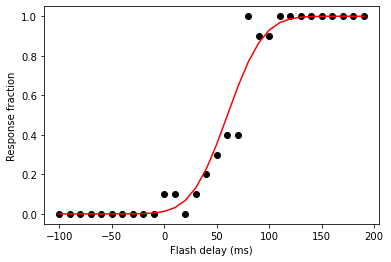

In [6]:
link = sm.families.links.probit()
family = sm.families.Binomial(link=link)
fit = sm.GLM.from_formula('fraction_correct~flash_delay', data=data, family=family).fit()
data['predicted_fraction_correct'] = fit.predict(data['flash_delay'])

figure, axes = plt.subplots(1, 1)
axes.plot(data['flash_delay'], data['fraction_correct'], 'ko')
axes.plot(data['flash_delay'], data['predicted_fraction_correct'], 'r-')
axes.set_xlabel('Flash delay (ms)')
axes.set_ylabel('Response fraction')

I have a feeling the next step will be to calculate the threshold (i.e., the point at which the function hits a response fraction of 0.5). Remember that the link function transforms the y-variable (i.e. response fraction) to a linear scale. 

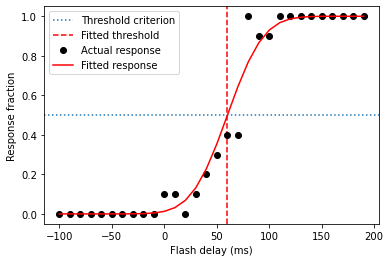

In [7]:
b = fit.params['Intercept']
m = fit.params['flash_delay']
link = sm.families.links.probit()

y = link(0.5)
fitted_threshold = (y - b) / m

figure, axes = plt.subplots(1, 1)
axes.axhline(0.5, ls=':', label='Threshold criterion')
#axes.axvline(threshold, ls='dashed', label='True threshold')
axes.axvline(fitted_threshold, color='r', ls='dashed', label='Fitted threshold')
axes.plot(data['flash_delay'], data['fraction_correct'], 'ko', label='Actual response')
axes.plot(data['flash_delay'], data['predicted_fraction_correct'], 'r-', label='Fitted response')
axes.set_xlabel('Flash delay (ms)')
axes.set_ylabel('Response fraction')
axes.legend()

You can get some basic information about the fit by printing the fit summary.

In [8]:
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       fraction_correct   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                Binomial   Df Model:                            1
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.5434
Date:                Fri, 27 Aug 2021   Deviance:                       1.4597
Time:                        11:29:19   Pearson chi2:                     1.53
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.2276      1.019     -2.186      0.029      -4.225      -0.230
flash_delay     0.0371      0.015      2.440      0.015       0.007       0.067
===============================================================================
"""